# Implied Volatility Demo

## Root-finding using Python

In [1]:
import numpy as np
import scipy.stats as spst
import scipy.optimize as spop
import matplotlib.pyplot as plt
import pyfeng as pf

In [2]:
def myFunc(x):
    return( x**3 + 2*x - 1 )

In [3]:
myFunc

<function __main__.myFunc(x)>

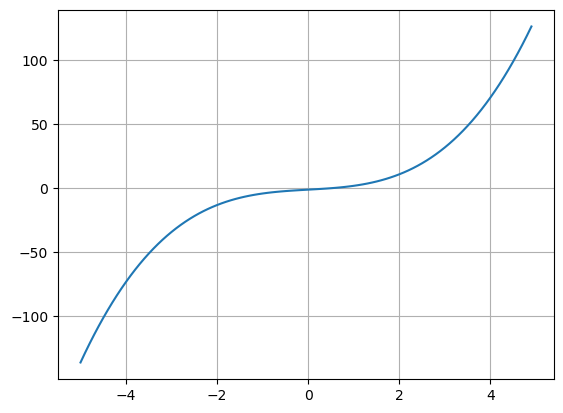

In [4]:
xx = np.arange(-5,5,0.1)
plt.plot(xx, myFunc(xx))
plt.grid()

In [6]:
x = spop.brentq(myFunc, -3, 3)
print(x, myFunc(x))

0.45339765151636313 -1.0635936575909e-13


In [7]:
# What if the intervals are not good?
spop.brentq(myFunc, 1, 3)

ValueError: f(a) and f(b) must have different signs

##  Lambda

In [8]:
# lambda is used for a quick definition of a function
g = lambda x: x**3 + 2*x - 10
g(5)

125

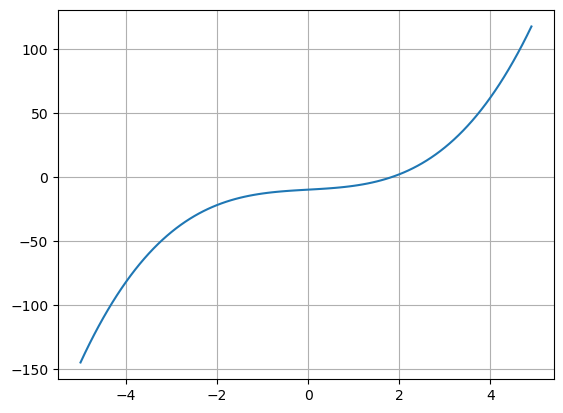

In [9]:
xx = np.arange(-5,5,0.1)
plt.plot(xx, g(xx))
plt.grid()

In [10]:
spop.brentq(g, 1, 3)

1.8474190378327324

### Lambda remembers the variables, not the values

In [11]:
a = 2
y = 10
f = lambda x: x**3 + a*x - y
f(5)

125

In [12]:
y = 5
f(5)

130

In [13]:
a = 5
f(5)

145

In [14]:
def myFunc2(x):
    b = y+1
    return( x**3 + b*x - y )

In [15]:
myFunc2(5)

150

In [16]:
b

NameError: name 'b' is not defined

## Solving Implied Volatility

In [18]:
## Define Black-Scholes Price as a function
def bsm_option_price(strike, spot, vol, texp, intr=0.0, divr=0.0, cp=1):
    vol_std = vol * np.sqrt(texp)
    df = np.exp(-texp*intr)
    forward = spot / df * np.exp(-texp*divr)
    d1 = np.log(forward/strike)/vol_std + 0.5*vol_std
    d2 = d1 - vol_std

    price = cp*df*(forward * spst.norm.cdf(cp*d1) - strike * spst.norm.cdf(cp*d2))
    return price

In [19]:
strike = 105
spot = 100
vol = 0.2
texp = 0.25

price = bsm_option_price(strike, spot, vol, texp)
print(price)

2.064019137898846


In [20]:
# We bind all the arguments EXCEPT vol
func_impvol = lambda _vol: bsm_option_price(strike, spot, _vol, texp) - price

In [21]:
# Let's find the implied vol
impvol = spop.brentq(func_impvol, 0.0001, 100)
print(f'{impvol*100:0.2f}%')

20.00%


In [22]:
# For different price
#price = 4
texp = 1
impvol = spop.brentq(func_impvol, 0.0001, 100)
print(f'{impvol*100:0.2f}%')

10.00%


### Class version

In [23]:
class BsmModel:
    vol, intr, divr = None, None, None

    def __init__(self, vol, intr=0.0, divr=0.0): # Constructor
        self.vol, self.texp, self.intr, self.divr = vol, texp, intr, divr

    def price(self, strike, spot, texp, cp=1):
        return bsm_option_price(strike, spot, self.vol, texp, intr=self.intr, divr=self.divr, cp=1)

    def impvol(self, price, strike, spot, texp, cp=1, setval=False):
        iv_func = lambda _vol: \
            bsm_option_price(strike, spot, _vol, texp, self.intr, self.divr, cp) - price
        vol = spop.brentq(iv_func, 0.00001, 10)
        if setval:
            self.vol = vol 
        return vol

In [24]:
bsm = BsmModel(vol=0.2)
price = bsm.price(strike=102, spot=100, texp=0.25, cp=1)
price

3.1062836665495652

In [26]:
bsm.impvol(price, strike=102, spot=100, texp=1,setval=True)

0.10000000000000066

In [28]:
# Let's assume price1 and price2 are given from market
price1 = 10
vol1 = bsm.impvol(price1, strike=102, spot=100, texp=1)
price2 = 13
vol2 = bsm.impvol(price2, strike=102, spot=100, texp=1, setval=True)

print(f'{vol1*100:0.2f}% {vol2*100:0.2f}%')

27.31% 34.87%


In [30]:
bsm.vol

0.3486576751417405

## Newton's Method
* Price is S-shaped curve as a function of volatility
* The inflection point is the best starting point

In [31]:
sigma = np.arange(0.0001, 7, 0.05)
m = pf.Bsm(sigma)

In [32]:
texp = 1
spot, strike = 100, 50
price = m.price(strike, spot, texp)

In [33]:
# inflection point: p''(sigma) = 0
sig_inf = np.sqrt(2*np.abs(np.log(strike/spot))/texp)
p_inf = pf.Bsm(sig_inf).price(strike, spot, texp)
vega = pf.Bsm(sig_inf).vega(strike, spot, texp)
print(sig_inf, p_inf, vega)

1.1774100225154747 63.0484054275244 19.947114020071634


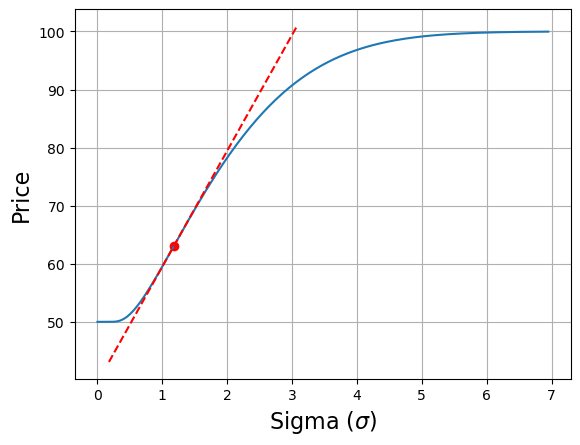

In [34]:
plt.plot(sigma, price)
plt.scatter(sig_inf, p_inf, color='r')
plt.plot(sig_inf + np.arange(-1,2,0.1), p_inf + vega*np.arange(-1,2,0.1), color='r', linestyle='--')
plt.xlabel('Sigma ($\sigma$)', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.grid()

In [ ]:
m.impvol(price, strike, spot, texp)

## PyFENG Implementation

In [35]:
import pyfeng as pf

In [41]:
m = pf.Bsm(sigma=0.2, intr=0.0, divr=0.0)
spot = np.array([100, 102, 104])
p = m.price(spot, 100, texp=1)
print(p)

[7.96556746 7.08449425 6.28006444]


In [42]:
vol = m.impvol(p, spot, 100, texp=1)
print(vol)

[0.2 0.2 0.2]
